读入一张图片

In [1]:
import cv2 as cv
import os
from matplotlib import image
from matplotlib import pyplot

In [2]:
path = os.path.join(os.getcwd(), ".." , "dataset", "picture_log", "battle_settlement.png")
# path = os.path.join(os.getcwd(), "..", "log", "picture_log", "log-2020-6-4-13-45-33-fighting.png")
print(os.path.exists(path))

True


- 使用 opencv 读取
- 从BGR转换为RGB
- 使用 pyplot 输出

(980, 1920)
uint8
(980, 1920)


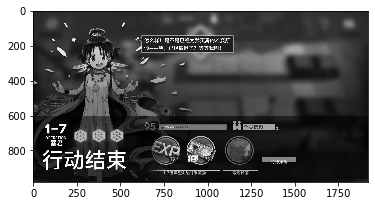

In [3]:
# image_read_by_cv = cv.imread(path)
image_read_by_cv = cv.imread(path, cv.IMREAD_GRAYSCALE)
print(image_read_by_cv.shape)
print(image_read_by_cv.dtype)
# print(image_read_by_cv)
print(image_read_by_cv.shape)
# b,g,r = cv.split(image_read_by_cv)
# image_read_by_cv = cv.merge([r,g,b])
# image_new = cv.cvtColor(image_read_by_cv, cv.COLOR_BGR2RGB)
pyplot.imshow(image_read_by_cv, cmap='gray')

使用 matplotlib 读取

(980, 1920, 4)


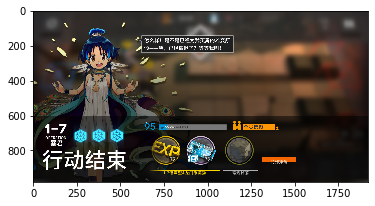

In [4]:
image_read_by_matplotlib = image.imread(path)
pyplot.imshow(image_read_by_matplotlib)
print(image_read_by_matplotlib.shape)

测试各个网络
- conv2d
- adaptive_avg_pool_2d
- linear

In [2]:
import torch

In [6]:
image_tensor = torch.tensor(image_read_by_cv, dtype=torch.float32)
print(image_tensor)
print(image_tensor.dtype)
print(image_tensor.shape)
image_tensor = image_tensor.to(torch.device('cuda'))
print(image_tensor)


tensor([[40., 38., 38.,  ..., 45., 45., 43.],
        [39., 39., 39.,  ..., 39., 39., 39.],
        [39., 39., 39.,  ..., 39., 39., 39.],
        ...,
        [43., 42., 41.,  ..., 46., 47., 45.],
        [45., 43., 43.,  ..., 48., 48., 47.],
        [46., 45., 45.,  ..., 48., 49., 48.]])
torch.float32
torch.Size([980, 1920])
tensor([[40., 38., 38.,  ..., 45., 45., 43.],
        [39., 39., 39.,  ..., 39., 39., 39.],
        [39., 39., 39.,  ..., 39., 39., 39.],
        ...,
        [43., 42., 41.,  ..., 46., 47., 45.],
        [45., 43., 43.,  ..., 48., 48., 47.],
        [46., 45., 45.,  ..., 48., 49., 48.]], device='cuda:0')


In [3]:
learn_rate = 0.1

class TestModule(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 使用三层
        #   - 卷积层（同时实现不同尺寸图像的输入）
        #   - 池化层（缩小图像尺寸）
        #   - 全连接层
        #   - 分类器输出
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = torch.nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        self.adaptive_avg_pool = torch.nn.AdaptiveAvgPool2d([16, 36])
        self.fc = torch.nn.Linear(10*16*36, 8)

    def forward(self, xb):

        # xb = torch.nn.functional.adaptive_avg_pool2d(xb, 4)
        # xb = xb.view(-1, 1, 980, 1920)
        # xb = xb.unsqueeze(0)
        # xb = xb.unsqueeze(0)
        # xb = self.conv1(xb)
        # xb = self.conv2(xb)
        # xb = self.conv3(xb)
        xb = torch.nn.functional.relu(self.conv1(xb))
        xb = torch.nn.functional.relu(self.conv2(xb))
        xb = torch.nn.functional.relu(self.conv3(xb))
        xb = self.adaptive_avg_pool(xb)
        xb = xb.view(-1, 10*16*36)
        xb = torch.sigmoid(self.fc(xb))

        # return xb.view(-1, xb.size(1))
        return xb


test_module = TestModule()
test_module.to(torch.device('cuda'))
optimize = torch.optim.SGD(test_module.parameters(), lr=learn_rate)

conv2d Test

In [15]:
with torch.no_grad():
    result_conv2d = test_module(image_tensor.unsqueeze(0).unsqueeze(0))
    print(result_conv2d.dtype)
    print(result_conv2d.shape)
    result_conv2d_cpu = result_conv2d.to(torch.device('cpu'))
    print(result_conv2d_cpu)
    # numpy.expand_dims(result_conv2d_cpu)
    # result_squeezed = numpy.squeeze(result_conv2d_cpu)
    # print(result_squeezed.dtype)
    # print(result_squeezed.shape)
    # print(result_squeezed[0].dtype)
    # print(result_squeezed[0].shape)
    # result_reshaped = numpy.reshape(result_squeezed)
    # pyplot.imshow(result_squeezed[11], cmap='gray')
    # for i in range(result_squeezed.shape[0]):
    #     pyplot.figure(i)
    #     target = result_squeezed[i]
    #     title = "title" + str(i+1)
    #     # pyplot.subplot(16, 1, i+1)
    #     pyplot.imshow(target, cmap='gray')
    #     # pyplot.title(title)
    #     pyplot.xticks([])
    #     pyplot.yticks([])
    # pyplot.show()

torch.float32
torch.Size([8])
tensor([0.0421, 0.6941, 0.2393, 0.5997, 0.3372, 0.9917, 0.0346, 0.0098])


展示数据:
- Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
    - 结果将 (980, 1920) 的图片转化为了 (490, 960) 的图片，channel 从 1 变成了 16
    - 输出的大小原始为 [1, 16, 490, 960]
- Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
    - 结果将 (980, 1920) 的图片(经由第一层的输出[490,960])转化为了 (245, 480) 的图片，channel 依然为 16
    - 输出的大小原始为 [1, 16, 245, 480]
- Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
    - 结果将 (980, 1920) 的图片(经由第一层的输出[490,960], 第二层的[245,480])转化为了 (123, 240) 的图片，channel 依然为 16
    - 输出的大小原始为 [1, 10, 123, 240]
- AdaptiveAvgPool2d([16, 36])
    - 将任意的输入都转化成了指定的输出



构建 dataloader
- 获得一个图片文件的路径list
- 获得一个图片文件对应tag的数据list
- 拆分出训练集、测试集、验证集
- 获得标签与数据的对应关系
- 填入 dataloader

In [4]:
file_list = os.listdir(os.path.join(os.getcwd(), "..", "dataset", "picture_log"))
tag_dic = ["level_selection",
           "restore_sanity_medicine",
           "restore_sanity_stone",
           "team_up",
           "fighting",
           "battle_settlement",
           "annihilation_settlement",
           "level_up"]

def map_func(filename:str) -> torch.Tensor:
    for index, tag in enumerate(tag_dic):
        if tag in filename:
            return torch.tensor(index, dtype=torch.long, device=torch.device('cuda'))

tag_list = list(map(map_func, file_list))

print(len(file_list))
print(file_list[0])
print(tag_dic)
print(len(tag_list))
print(tag_list[2])

3298
annihilation_settlement (10).png
['level_selection', 'restore_sanity_medicine', 'restore_sanity_stone', 'team_up', 'fighting', 'battle_settlement', 'annihilation_settlement', 'level_up']
3298
tensor(6, device='cuda:0')


In [14]:
from torch.utils.data import Dataset
# from torch.utils.data.dataset import T_co

def default_loader(image_path:str):
    image_loaded = cv.imread(
        os.path.join(
            os.getcwd(),"..","dataset","picture_log", image_path)
        ,cv.IMREAD_GRAYSCALE)
    image_tensor = torch.tensor(image_loaded, device=torch.device('cuda'),dtype=torch.float32).unsqueeze(0)
    print(f"loaded image shape: {image_tensor.shape()}")
    return image_tensor


class TrainSet(Dataset):
    def __init__(self, image_name_list:list, tags:int, loader=default_loader)-> None:
        self.images = image_name_list
        self.tags = tags
        self.loader = loader
    def __getitem__(self, index: int):
        data = self.loader(self.images[index])
        tag = self.tags[index]
        return data,tag
    def __len__(self)-> int:
        return len(self.images)

测试 TrainSet

In [7]:
train_set = TrainSet(file_list, tag_list)
print(train_set)
print(train_set.__getitem__(3))
print(train_set.__len__())

(tensor([[[37., 36., 36.,  ..., 39., 39., 39.],
         [39., 38., 38.,  ..., 41., 41., 40.],
         [39., 38., 38.,  ..., 41., 41., 40.],
         ...,
         [32., 31., 31.,  ..., 33., 33., 33.],
         [32., 32., 32.,  ..., 34., 34., 33.],
         [34., 33., 33.,  ..., 36., 36., 36.]]], device='cuda:0'), tensor(6, device='cuda:0'))
3298


构建 DataLoader

In [12]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
print(train_loader)
print(iter(train_loader).next()[0].size())
print(iter(train_loader).next()[1].size())

torch.Size([1, 1, 980, 1920])
torch.Size([1])


cross_entropy 函数测试

In [9]:
loss_function = torch.nn.functional.cross_entropy
pred_test = torch.tensor([[0.1,0.3,0.4,0.9]],dtype=torch.float32)
print(pred_test.size())
target_test = torch.tensor([3], dtype=torch.long)
print(target_test.size())
print(loss_function(pred_test, target_test))


torch.Size([1, 4])
torch.Size([1])
tensor(0.9573)


In [10]:
with torch.no_grad():
    pred_test = test_module(iter(train_loader).next()[0])
    yb = iter(train_loader).next()[1]
    print(pred_test.size())
    print(yb.size())
    print(loss_function(pred_test,yb))

torch.Size([8, 8])
torch.Size([8])
tensor(2.0431, device='cuda:0')


准备 fit 函数

In [15]:
def fit(epochs:int):
    for epoch in range(epochs):
        for xb, yb in train_loader:
            pred = test_module(xb)
            loss = loss_function(pred, yb)

            loss.backward()
            optimize.step()
            optimize.zero_grad()

    xb, yb = train_set.__getitem__(30)
    print(loss_function(test_module(xb), yb))

fit(1)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [16, 1, 3, 3], but got 3-dimensional input of size [1, 980, 1920] instead

cuda 设备检查


In [14]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.device('cuda:0')))
print(torch.device('cuda:0'))
print(torch.cuda.get_device_name(0))
print(torch.cuda.current_device())


True
1
GeForce GTX 950M
cuda:0
GeForce GTX 950M
0
